In [1]:
import ssl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as plt
from urllib.request import urlretrieve

Cargo el archivo localmente porque me estaba dando problemas la descarga

In [3]:
#%%time
#ncfile, header = urlretrieve('https://meteo.unican.es/work/josipa/euro-cordex-cmip6/static_data/geo_em.d01_EUR-11_newLAI_LANDMATE_final.nc')

In [4]:
#Open the dataset
#ds = xr.open_mfdataset(ncfile)
ds = xr.open_dataset(r'\Users\dsp295\Desktop\TFG\geo_em.d01_EUR-11_newLAI_LANDMATE_final.nc')
ds

<xarray.Dataset>
Dimensions:     (Time: 1, south_north: 432, west_east: 444,
                 south_north_stag: 433, west_east_stag: 445, land_cat: 21,
                 soil_cat: 16, month: 12)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month
Data variables: (12/74)
    Times       (Time) |S19 ...
    XLAT_M      (Time, south_north, west_east) float32 ...
    XLONG_M     (Time, south_north, west_east) float32 ...
    XLAT_V      (Time, south_north_stag, west_east) float32 ...
    XLONG_V     (Time, south_north_stag, west_east) float32 ...
    XLAT_U      (Time, south_north, west_east_stag) float32 ...
    ...          ...
    OA4SS       (Time, south_north, west_east) float32 ...
    OL1SS       (Time, south_north, west_east) float32 ...
    OL2SS       (Time, south_north, west_east) float32 ...
    OL3SS       (Time, south_north, west_east) float32 ...
    OL4SS       (Time, south_north, west_east) float32 ...
    BATHYMETRY  (Time, south_north, west_east) float32 ...
Attributes: (12/49)
    TITLE:                           OUTPUT FROM GEOGRID V4.3.1
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        445
    SOUTH-NORTH_GRID_DIMENSION:      433
    BOTTOM-TOP_GRID_DIMENSION:       0
    WEST-EAST_PATCH_START_UNSTAG:    1
    ...                              ...
    sr_y:                            1
    FLAG_MF_XY:                      1
    FLAG_LAI12M:                     1
    FLAG_VAR_SSO:                    1
    FLAG_LAKE_DEPTH:                 1
    FLAG_BATHYMETRY:                 1

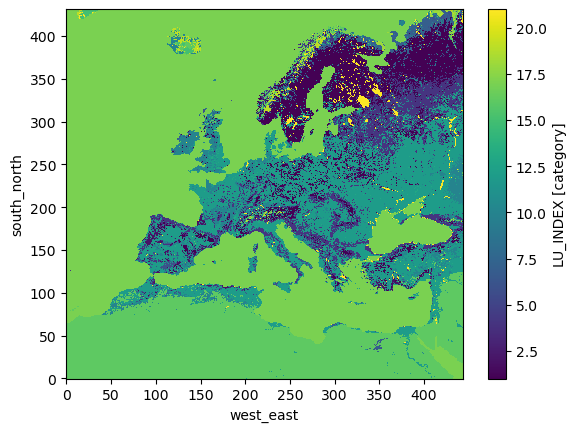

In [5]:
ds['LU_INDEX'][0].plot()

In [6]:
#Opens the 'VEGPARM.TBL' file, reads its content, and splits it into lines
with open('VEGPARM.TBL') as fp:
    table_as_list = fp.read().splitlines()

#The for loop looks for the tables in the file and stores their names, sizes, and locations in a dictionary called 'tables_names'
tables_names = {}
for i, line in enumerate(table_as_list):
    if line == 'Vegetation Parameters':
        name = table_as_list[i+1]
        table_size = int(table_as_list[i+2].split(',')[0])
        tables_names[name] = dict(size = table_size, start = i+2, end = i+2+table_size)
#tables_names

In [7]:
#The function returns the values of "size", "start" and "end" of the called table
def obtain_table_values(tables_names, tabla):
    if tabla in tables_names:
        valores = tables_names[tabla]
        size = valores['size']
        start = valores['start']
        end = valores['end']
        return size, start, end
    else:
        return None
#obtain_table_values(tables_names, 'MODIFIED_IGBP_MODIS_NOAH')

In [8]:
#The function reads line by line and finds the name of the table, then return the data below in a str list
def read_tables(tables_names, tabla):
    datos_tabla = []
    if tabla in tables_names:
        for i, line in enumerate(table_as_list):
            if line == tabla:
                datos_tabla = table_as_list[obtain_table_values(tables_names,tabla)[1]:int(obtain_table_values(tables_names,tabla)[2]+1)]  # 1 for "start", 2 for "end"
        return datos_tabla
    else:
        return None
#read_tables(tables_names,'MODIFIED_IGBP_MODIS_NOAH')

In [9]:
#The function creates a DataFrame from the list returned from the function "read_table" and set the index and columns names
def tables_to_df(tables_names, tabla):
    if tabla in tables_names:
        df = pd.DataFrame(read_tables(tables_names, tabla))
        df.rename(columns={0:'col'},inplace=True) #renames the first column of the DataFrame to 'col'
        df = df.col.str.split(",", expand=True) #splits the 'col' column of the DataFrame based on commas and expands it into separate columns
        df = df.drop(0, axis = 1) # drops the first column of the DataFrame 
        nombres = df.iloc[0,1]
        nombres = nombres.split()
        nombres.append("j")
        df = df.set_index(df.iloc[:, -1])
        df = df[1:]
        df.columns = nombres
        df.index.name = None
        df = df.drop("j", axis = 1)
        df.columns = df.columns.str.strip("'") #Eliminates the ' in the column names
        df.index = df.index.str.strip()
        df.index = df.index.str.strip("'") #Eliminates the blank spaces and ' in the index
        return df
    else:
        return None
    
tables_to_df(tables_names,'MODIFIED_IGBP_MODIS_NOAH')

,SHDFAC,NROOT,RS,RGL,HS,SNUP,MAXALB,LAIMIN,LAIMAX,EMISSMIN,EMISSMAX,ALBEDOMIN,ALBEDOMAX,Z0MIN,Z0MAX,ZTOPV,ZBOTV
Evergreen Needleleaf Forest,.70,4,125.,30.,47.35,0.08,52.,5.00,6.40,.950,.950,.12,.12,.50,.50,17.0,8.5
Evergreen Broadleaf Forest,.95,4,150.,30.,41.69,0.08,35.,3.08,6.48,.950,.950,.12,.12,.50,.50,35.0,1.0
Deciduous Needleleaf Forest,.70,4,150.,30.,47.35,0.08,54.,1.00,5.16,.930,.940,.14,.15,.50,.50,14.0,7.0
Deciduous Broadleaf Forest,.80,4,100.,30.,54.53,0.08,58.,1.85,3.31,.930,.930,.16,.17,.50,.50,20.0,11.5
Mixed Forests,.80,4,125.,30.,51.93,0.08,53.,2.80,5.50,.930,.970,.17,.25,.20,.50,18.0,10.0
Closed Shrublands,.70,3,300.,100.,42.00,0.03,60.,0.50,3.66,.930,.930,.25,.30,.01,.05,0.50,0.10
Open Shrublands,.70,3,170.,100.,39.18,0.035,65.,0.60,2.60,.930,.950,.22,.30,.01,.06,0.50,0.10
Woody Savannas,.70,3,300.,100.,42.00,0.03,60.,0.50,3.66,.930,.930,.25,.30,.01,.05,0.50,0.10
Savannas,.50,3,70.,65.,54.53,0.04,50.,0.50,3.66,.920,.920,.20,.20,.15,.15,0.50,0.10
Grasslands,.80,3,40.,100.,36.35,0.04,70.,0.52,2.90,.920,.960,.19,.23,.10,.12,0.50,0.01


In [20]:
#The function reads the returned Dataframe from tables_to_df, creates a list with the values of the
#LU_INDEX variable from the Dataset and returns a numpy array with its matching value from the Dataframe
def cross_tables(tables_names,tabla,column):
    df = tables_to_df(tables_names,tabla)
    lu_index = ds['LU_INDEX'][0,:,:].to_numpy().reshape(1, 432, 444)#Same dimmensions as the LU_INDEX variable in the DataSet
    if tabla in tables_names and column in df.columns:
        col = df.columns.get_loc(column)#Obtain the iloc for the given column
        new_map = lu_index.copy()
        new_map[new_map == 21] = 17#21 stands for Lakes in land use index. It is assigned to 17 which is Water in MODIS NOAH data table.
        for i in range(len(df.index)):
            new_map[new_map == i+1] = df.iloc[i,col]
        return new_map
    else:
        return None
#cross_tables(tables_names,'MODIFIED_IGBP_MODIS_NOAH','SNUP')

In [22]:
#The function calls all previous functions
def megafunction(tables_names,tabla,column):
    obtain_table_values(tables_names, tabla)
    read_tables(tables_names, tabla)
    tables_to_df(tables_names, tabla)
    return cross_tables(tables_names,tabla,column)
#megafunction(tables_names,'MODIFIED_IGBP_MODIS_NOAH','LAIMIN')

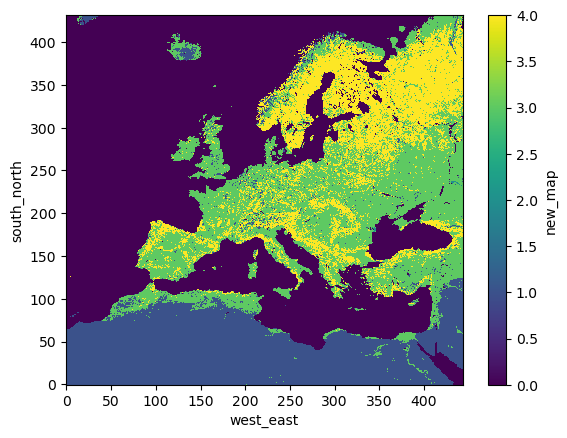

In [30]:
#Add the new data to the DataSet and plot it
new_map= xr.DataArray(megafunction(tables_names,'MODIFIED_IGBP_MODIS_NOAH','NROOT'), dims=['Time', 'south_north', 'west_east'])
ds['new_map'] = new_map
ds['new_map'][0].plot()

In [14]:
df = tables_to_df(tables_names,'MODIFIED_IGBP_MODIS_NOAH')
len(df.index)

20